## <b>Import libraries<b>

In [1]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import f1_score
from sklearn import model_selection
%matplotlib inline

In [2]:
#drew inspiration from
#https://github.com/dmesquita/understanding_pytorch_nn and
#https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb
#https://github.com/nyu-mll/DS-GA-1011-Fall2017/blob/master/week%20eight/Week%20Eight%20Solutions.ipynb
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
#https://github.com/claravania/lstm-pytorch/blob/master/model.py
#https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130
#https://github.com/hpanwar08/sentence-classification-pytorch/blob/master/Sentiment%20analysis%20pytorch.ipynb

## <b> Data Processing<b>

In [3]:
train = pd.read_csv("../train.csv")

In [4]:
#create labels

In [5]:
labels = ['CAPS', 'Obscenity', 'Threat', 'hatespeech', 'namecalling', 'negprejudice', 'noneng', 'porn', 'stereotypes']

for label in labels:
    cols = [label + str(x) for x in range(1,8)]
    train[label + '_num_yes'] = train[cols].sum(axis = 1)
    train[label] = pd.Series(train[label + '_num_yes'] >= 2).astype(int)

In [6]:
train = train.loc[train['clean_tweet'].isnull() == False,]

In [7]:
train.reset_index(inplace = True, drop = True)

In [8]:
vocab = Counter()

for text in train.clean_tweet:
    for word in text.split(' '):
        vocab[word.lower()]+=1

total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    index2word = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i+1
        index2word[i+1] = word.lower()

    return word2index, index2word

word2index, index2word = get_word_2_index(vocab)

In [9]:
word2index['PAD'] = 0
index2word[0] = 'PAD'

total_words = total_words + 1

In [10]:
def pad_data(s, length):
    padded = np.zeros((length,), dtype = np.int64)
    if len(s) > length: 
        padded = s[:length]
    else:
        padded[:len(s)] = s
    return np.array(padded)

In [11]:
train['seq_len'] = [len(x.split(' ')) for x in train['clean_tweet']]

train['numeric'] = [[word2index[y] for y in x.split(' ')] for x in train['clean_tweet']]

train['padded_tweet'] = [pad_data(x, 10) for x in train.numeric]

In [ ]:
#if we want validation accuracy to better resemble test accuracy, need to create vocab on training only

In [12]:
train_sub, validation = model_selection.train_test_split(train, test_size = 0.2, random_state = 123)

In [13]:
# subclass the custom dataset class with torch.utils.data.Dataset
# implement __len__ and __getitem__ function
class VectorizeData(Dataset):
    def __init__(self, df, label, maxlen=20):
        self.df = df
        self.label = label

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.padded_tweet[idx]
        y = self.df[self.label][idx]
        lens = self.df.seq_len[idx]
        return X,y,lens

In [39]:
train_sub.reset_index(inplace = True, drop = True)

In [55]:
validation.reset_index(inplace = True, drop = True)

In [41]:
data = VectorizeData(train_sub, label = 'hatespeech')

dl = DataLoader(data, batch_size = 32, shuffle = True)

In [44]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, batch_size):
        super(LSTMClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)
        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax()
        self.dropout_layer = nn.Dropout(p=0.2)
        self.batch_size = batch_size
        #self.hidden = self.init_hidden(batch_size)

    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)), \
               autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))

    def forward(self, batch): #removed lengths
        #should reinitalize hidden states before each batch?
        self.hidden = self.init_hidden(batch_size)
        embeds = self.embedding(batch)
        #packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(embeds, self.hidden)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)
        return output

In [86]:
hidden_size = 100 
num_classes = 2
learning_rate = 0.01
num_epochs = 5
batch_size = 32
#momentum = 0.9

In [46]:
len(dl)

100

In [47]:
total_words

11059

In [48]:
3892/99

39.313131313131315

In [87]:
#add 1 because of pad token
net = LSTMClassifier(total_words, hidden_size, hidden_size, num_classes, batch_size)

# Loss and Optimizer
criterion = nn.NLLLoss(weight = torch.Tensor([1/39,1]))  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#, momentum = momentum, weight_decay = 0.0001)
#scheduler = MultiStepLR(optimizer, milestones=[31,62,93,124], gamma = 0.1)

losses = []

num_batch = len(dl) - 1
# Train the Model
for epoch in range(num_epochs):
    it = iter(dl)
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(tweets)
        loss = criterion(outputs, labels)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train.clean_tweet)//batch_size, loss.data[0]))
            
    #scheduler.step()

Epoch [1/5], Step [4/124], Loss: 1.7614
Epoch [1/5], Step [8/124], Loss: 1.3704
Epoch [1/5], Step [12/124], Loss: 0.4660
Epoch [1/5], Step [16/124], Loss: 0.6943
Epoch [1/5], Step [20/124], Loss: 0.9303
Epoch [1/5], Step [24/124], Loss: 0.5175
Epoch [1/5], Step [28/124], Loss: 0.3895
Epoch [1/5], Step [32/124], Loss: 0.4187
Epoch [1/5], Step [36/124], Loss: 0.1964
Epoch [1/5], Step [40/124], Loss: 0.1433
Epoch [1/5], Step [44/124], Loss: 0.1082
Epoch [1/5], Step [48/124], Loss: 0.7923
Epoch [1/5], Step [52/124], Loss: 0.6039
Epoch [1/5], Step [56/124], Loss: 0.5231
Epoch [1/5], Step [60/124], Loss: 0.4567
Epoch [1/5], Step [64/124], Loss: 0.6987
Epoch [1/5], Step [68/124], Loss: 0.1952
Epoch [1/5], Step [72/124], Loss: 0.1467
Epoch [1/5], Step [76/124], Loss: 0.2159
Epoch [1/5], Step [80/124], Loss: 1.2461
Epoch [1/5], Step [84/124], Loss: 0.3998
Epoch [1/5], Step [88/124], Loss: 0.2117
Epoch [1/5], Step [92/124], Loss: 0.3645
Epoch [1/5], Step [96/124], Loss: 0.2019
Epoch [2/5], Step 

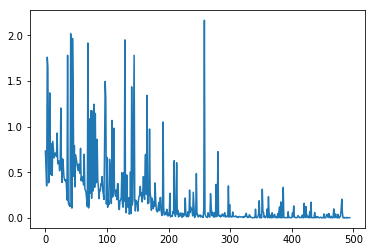

In [88]:
plt.plot(losses)

In [89]:
data = VectorizeData(validation, label = 'hatespeech')

dl2 = DataLoader(data, batch_size = 32, shuffle = False)

In [90]:
predictions = []
pred_labels = []
#get training predictions
it = iter(dl2)
num_batch = len(dl2) - 1
# Loop over all batches
for i in range(num_batch):
    batch_x,batch_y,batch_len = next(it)
    tweets = Variable(batch_x.transpose(0,1))
    labels = Variable(batch_y)
    lengths = Variable(batch_len)
    # Forward + Backward + Optimize
    outputs = net(tweets)
    _, pred = torch.max(outputs.data, 1)
    predictions.extend(list(pred.numpy()))
    pred_labels.extend(list(labels.data.numpy()))

In [91]:
pd.Series(predictions).value_counts()

0    734
1     34
dtype: int64

In [92]:
f1_score(pred_labels, predictions)
#overfits to training data almost perfectly with 10 epochs, but validation accuracy is low

0.51724137931034486